### Random Forest     
Example of Dr. Ravi Shroff's [policy research](https://5harad.com/papers/frisky.pdf) on NYPD's *Stop-and-Frisk* in the early 1990s. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import random
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [61]:
# load data
train_url = "https://raw.githubusercontent.com/Jihenghuang/the-talking-machines/master/data/random-forest/sqf_train_cpw.csv"
test_url = "https://raw.githubusercontent.com/Jihenghuang/the-talking-machines/master/data/random-forest/sqf_test_cpw.csv"

train_set = pd.DataFrame.from_csv(train_url, index_col = False)
test_set = pd.DataFrame.from_csv(test_url, index_col = False)

In [62]:
# Explore the data a bit
# feature names and number of rows/cols
print train_set.columns
print train_set.shape

Index([u'id', u'year', u'found.weapon', u'found.gun', u'arrested',
       u'suspect.race', u'suspect.age', u'suspect.build', u'suspect.sex',
       u'suspect.height', u'suspect.weight', u'stopped.bc.desc',
       u'stopped.bc.violent', u'stopped.bc.other', u'stopped.bc.object',
       u'stopped.bc.casing', u'stopped.bc.lookout', u'stopped.bc.drugs',
       u'stopped.bc.clothing', u'stopped.bc.furtive', u'stopped.bc.bulge',
       u'precinct', u'inside.outside', u'location.housing',
       u'observation.period', u'officer.uniform', u'additional.report',
       u'additional.investigation', u'additional.proximity',
       u'additional.evasive', u'additional.associating',
       u'additional.direction', u'additional.highcrime', u'additional.time',
       u'additional.sights', u'additional.other', u'radio.run', u'day',
       u'month', u'time.period'],
      dtype='object')
(310652, 40)


In [63]:
train_set.head()

,id,year,found.weapon,found.gun,arrested,suspect.race,suspect.age,suspect.build,suspect.sex,suspect.height,...,additional.associating,additional.direction,additional.highcrime,additional.time,additional.sights,additional.other,radio.run,day,month,time.period
0,1565349,2009,False,False,False,hispanic,-0.016428,thin,male,0.027557,...,False,True,False,False,False,False,False,Saturday,January,6
1,2582029,2010,False,False,False,black,-0.418262,thin,male,1.007377,...,False,True,False,False,False,False,False,Friday,October,5
2,1969776,2009,False,False,False,hispanic,1.389991,thin,male,-1.605475,...,False,True,False,False,False,False,True,Monday,September,6
3,2324214,2010,True,False,False,black,1.691367,medium,male,0.680770,...,False,False,False,True,False,False,False,Friday,May,6
4,1722977,2009,False,False,False,black,-0.518721,medium,male,1.333983,...,False,False,True,True,False,False,False,Saturday,April,1


In [64]:
# distribution of various features in the training set
print train_set['year'].value_counts(), "\n"
print train_set['found.weapon'].value_counts(), "\n"
print train_set['precinct'].value_counts().sort_values(ascending = False)[:5], "\n"
print train_set['suspect.race'].value_counts()

2009    156592
2010    154060
Name: year, dtype: int64 

False    299677
True      10975
Name: found.weapon, dtype: int64 

75    18587
73    16775
32    13785
44    13499
46    13443
Name: precinct, dtype: int64 

black              193723
hispanic            94374
white               12451
other                5346
asian                4054
native.american       704
Name: suspect.race, dtype: int64


In [6]:
# proportion of features in the training set
print train_set['suspect.race'].value_counts() / np.sum(train_set['suspect.race'].value_counts()), "\n"
print train_set['suspect.sex'].value_counts() / np.sum(train_set['suspect.sex'].value_counts()), "\n"

black              0.623601
hispanic           0.303793
white              0.040080
other              0.017209
asian              0.013050
native.american    0.002266
Name: suspect.race, dtype: float64 

male      0.965389
female    0.034611
Name: suspect.sex, dtype: float64 



In [65]:
# Warmup question:
# which precinct in the training set has the highest percentage of successful stops, i.e. stops where found.weapon==True?
temp = train_set.groupby('precinct')
precinct_list = []
for name, group in temp:
    precinct_list.append((name, np.mean(group['found.weapon'])))
print sorted(precinct_list, reverse=True, key=lambda x: x[1])[:5]

[(17, 0.33663366336633666), (13, 0.28440366972477066), (14, 0.27898137590269861), (1, 0.22265625), (18, 0.20423600605143721)]


In [8]:
print train_set.shape
print test_set.shape

(310652, 40)
(296521, 40)


In [67]:
# join and re-split data to get all categories
train_set['set'] = 'train'
test_set['set'] = 'test'
joined_data = train_set.append(test_set)
# dataset = pd.concat([X_train, X_valid], axis=0) 

# select all non-real-valued columns (besides 'set' and 'id') and convert to one-hot encoding
col_names = joined_data.columns
col_names = col_names.difference(['id', 'set', 'suspect.age', 'suspect.weight', 'suspect.height', 'observation.period'])
joined_data = pd.get_dummies(data=joined_data, columns=col_names, sparse=True)

In [68]:
# what does the data look like after converting to one-hot encoding?
print len(list(joined_data.columns))
print list(joined_data.columns)[:5]

179
['id', 'suspect.age', 'suspect.height', 'suspect.weight', 'observation.period']


In [11]:
print len(list(joined_data))

179


In [69]:
# remove redundant columns (binary columns of the form 'variable_False')
redundant_cols = []
for name in list(joined_data):
    if "False" in name:
        redundant_cols.append(name)
joined_data.drop(redundant_cols, inplace=True, axis=1)

# verify that redundant columns have been removed
print len(list(joined_data.columns))
print list(joined_data.columns)[:5]

153
['id', 'suspect.age', 'suspect.height', 'suspect.weight', 'observation.period']


In [13]:
# (remove this line when running this cell) pd concat example
# df2 = pd.DataFrame({ 'A' : 1.,
#    ....:                      'B' : pd.Timestamp('20130102'),
#    ....:                      'C' : pd.Series(1,index=list(range(4)),dtype='float32'),
#    ....:                      'D' : np.array([3] * 4,dtype='int32'),
#    ....:                      'E' : pd.Categorical(["test","train","test","train"]),
#    ....:                      'F' : 'foo' })
# df3 = pd.DataFrame({ 'A' : 1.,
#    ....:                      'B' : pd.Timestamp('20130103'),
#    ....:                      'C' : pd.Series(1,index=list(range(5)),dtype='float32'),
#    ....:                      'D' : np.array([4] * 5,dtype='int32'),
#    ....:                      'E' : pd.Categorical(["test","train","test","train","test"]),
#    ....:                      'F' : 'foo' })


# print pd.concat([df2, df3], axis = 1)
# print pd.concat([df2, df3], axis = 0)

In [14]:
# split data again
train = joined_data.loc[joined_data['set'] == 'train']
train = train.drop(['set'], axis=1)
test = joined_data.loc[joined_data['set'] == 'test']
test = test.drop(['set'], axis=1)

In [15]:
# split training data into features and outcome (numpy arrays, to feed to sklearn algorithms)
label_train = np.ravel(train[['found.weapon_True']].values)
pred_train = train.drop(['id', 'arrested_True', 'found.weapon_True', 'found.gun_True'], axis=1)

print pred_train.head()
pred_train = pred_train.values

   suspect.age  suspect.height  suspect.weight  observation.period  \
0    -0.016428        0.027557       -0.372207           -0.024228   
1    -0.418262        1.007377       -0.719462           -0.225465   
2     1.389991       -1.605475       -0.372207           -0.225465   
3     1.691367        0.680770       -0.372207           -0.225465   
4    -0.518721        1.333983        0.148676           -0.225465   

   additional.associating_True  additional.direction_True  \
0                          NaN                        1.0   
1                          NaN                        1.0   
2                          NaN                        1.0   
3                          NaN                        0.0   
4                          NaN                        0.0   

   additional.evasive_True  additional.highcrime_True  \
0                      1.0                        0.0   
1                      1.0                        0.0   
2                      0.0               

In [17]:
# format test data
results = test.copy()
label_test = np.ravel(test[['found.weapon_True']].values)
pred_test = test.drop(['id', 'found.weapon_True', 'arrested_True', 'found.gun_True'], axis=1)

# remove unicode 'u'
feature_names = list(pred_test.columns.values)
pred_test = pred_test.values 

In [26]:
# default
# AUC:      0.739404038992
# Accuracy: 0.966036132348

In [24]:
# num_trees = 20, 
# n_estimators=num_trees, n_jobs=4, min_samples_split=10, verbose=2, oob_score = True
# AUC:      0.801864435448
# Accuracy: 0.966484667191

In [25]:
# num_trees = 30
# n_estimators=num_trees, n_jobs=4, min_samples_split=10, verbose=2, oob_score = True
# AUC:      0.809404023205
# Accuracy: 0.966282320645

In [20]:
# train the model with 500 trees, 4 parallel processes, and 10 min samples to split a node 
num_trees = 500
rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=4, min_samples_split=10, verbose=2, oob_score = True)
rf.fit(X=pred_train, y=label_train)

# generate predictions and add them to 'results'
rf_predictions = rf.predict_proba(pred_test)[:, 1]
results['preds'] = rf_predictions

# get AUC score (produce probabilistic predictions)
print roc_auc_score(label_test, rf_predictions)

# get accuracy (predict the class)
rf_predictions_class = rf.predict(pred_test)
print accuracy_score(label_test, rf_predictions_class, normalize=True)

# Questions:
# What happens to AUC if I change the target variable to found.gun_True?
# What happens to AUC and accuracy if I forgot to take out found.weapon_True from the features?  Why?
# How does AUC change if I forgot to remove 'arrested_True'?  Does that mean I should remove it?
# What are the most five important features?

feature_importances = list(rf.feature_importances_)
feature_list = []
for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i], feature_importances[i]))
print sorted(feature_list, reverse=True, key=lambda x: x[1])

In [32]:
# target 'found.weapon_True'
# default
# AUC:      0.739404038992
# Accuracy: 0.966036132348

# What happens to AUC if I change the target variable to found.gun_True?

label_test = np.ravel(test[['found.gun_True']].values)
label_train = np.ravel(train[['found.gun_True']].values)

pred_test = test.drop(['id', 'arrested_True', 'found.weapon_True', 'found.gun_True'], axis=1)
pred_test = pred_test.values 
pred_train = train.drop(['id', 'arrested_True', 'found.weapon_True', 'found.gun_True'], axis=1)
pred_train = pred_train.values

rf = RandomForestClassifier()
rf.fit(X=pred_train, y=label_train)
# generate predictions and add them to 'results'
rf_predictions = rf.predict_proba(pred_test)[:, 1]
results['preds'] = rf_predictions

# get AUC score (produce probabilistic predictions)
print roc_auc_score(label_test, rf_predictions)

# get accuracy (predict the class)
rf_predictions_class = rf.predict(pred_test)
print accuracy_score(label_test, rf_predictions_class, normalize=True)

0.555809181396
0.995996910843


In [34]:
# What happens to AUC and accuracy if I forgot to take out found.weapon_True from the features?  Why?

label_test = np.ravel(test[['found.weapon_True']].values)
label_train = np.ravel(train[['found.weapon_True']].values)

pred_test = test.drop(['id', 'arrested_True', 'found.gun_True'], axis=1)
pred_test = pred_test.values 
pred_train = train.drop(['id', 'arrested_True', 'found.gun_True'], axis=1)
pred_train = pred_train.values

rf = RandomForestClassifier()
rf.fit(X=pred_train, y=label_train)
# generate predictions and add them to 'results'
rf_predictions = rf.predict_proba(pred_test)[:, 1]
results['preds'] = rf_predictions

# get AUC score (produce probabilistic predictions)
print roc_auc_score(label_test, rf_predictions)

# get accuracy (predict the class)
rf_predictions_class = rf.predict(pred_test)
print accuracy_score(label_test, rf_predictions_class, normalize=True)

0.999999995187
0.999946040921


In [36]:
# How does AUC change if I forgot to remove 'arrested_True'?  Does that mean I should remove it?

pred_test = test.drop(['id', 'found.weapon_True', 'found.gun_True'], axis=1)
pred_test = pred_test.values 
pred_train = train.drop(['id', 'found.weapon_True', 'found.gun_True'], axis=1)
pred_train = pred_train.values

label_test = np.ravel(test[['found.weapon_True']].values)
label_train = np.ravel(train[['found.weapon_True']].values)

rf = RandomForestClassifier()
rf.fit(X=pred_train, y=label_train)
# generate predictions and add them to 'results'
rf_predictions = rf.predict_proba(pred_test)[:, 1]
results['preds'] = rf_predictions

# get AUC score (produce probabilistic predictions)
print roc_auc_score(label_test, rf_predictions)

# get accuracy (predict the class)
rf_predictions_class = rf.predict(pred_test)
print accuracy_score(label_test, rf_predictions_class, normalize=True)

0.87835681544
0.967115313924


In [44]:
# Questions:
# What are the most five important features?

label_test = np.ravel(test[['found.weapon_True']].values)
label_train = np.ravel(train[['found.weapon_True']].values)

pred_test = test.drop(['id', 'arrested_True', 'found.weapon_True', 'found.gun_True'], axis=1)
pred_test = pred_test.values 
pred_train = train.drop(['id', 'arrested_True', 'found.weapon_True', 'found.gun_True'], axis=1)
pred_train = pred_train.values

rf = RandomForestClassifier()
rf.fit(X=pred_train, y=label_train)
# generate predictions and add them to 'results'
rf_predictions = rf.predict_proba(pred_test)[:, 1]
results['preds'] = rf_predictions

feature_importances = list(rf.feature_importances_)
feature_list = []
for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i], feature_importances[i]))
print sorted(feature_list, reverse=True, key=lambda x: x[1])[:5]

[('suspect.age', 0.069421910066146425), ('stopped.bc.object_True', 0.064449065124755595), ('suspect.weight', 0.062975929480893839), ('suspect.height', 0.055719733901685484), ('observation.period', 0.031846405617966041)]


C:\Users\jhuan\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\jhuan\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jhuan\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jhuan\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

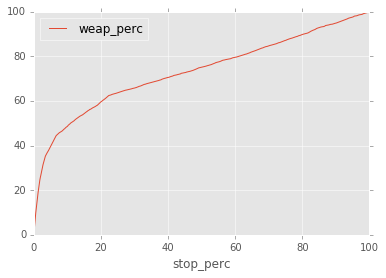

In [60]:
# Plotting:
# Make a recovery plot: if you used the RF model to rank stops by model-predicted likelihood of weapon recovery, 
# from highest to lowest, what percent of weapons would you recover if you made the best x percent of stops?
# The plot should have percent of stops on the x axis and percent weapons recovered on the y axis

# 1) order results by column 'preds'
results = results.sort(['preds'], ascending=False)

# 2) add a column to results which is the cumulative sum of found.weapon_True
plot_data = results[['found.weapon_True', 'preds']]
plot_data['weap_sum'] = plot_data['found.weapon_True'].cumsum()

# 3) use the above cumulative sum to make a column which shows percent weapons recovered
plot_data['weap_perc'] = 100*plot_data['weap_sum']/plot_data['found.weapon_True'].sum()

# 4) add a column which counts the stops
s = [j for j in range(1,296522)]
plot_data['nstop'] = s

# 5) use the above stop count column to make a column which shows percent of all stops
plot_data['stop_perc'] = 100*plot_data['nstop']/plot_data.shape[0]

# 6) restrict to just the columns from 3) and 5), downsample to maybe 1000 rows
plot_data = plot_data[['stop_perc', 'weap_perc']]
rows = random.sample(plot_data.index, 1000)
plot_data = plot_data.ix[rows]

# 7) sort everything in ascending order by the column from 5), then plot.
plot_data = plot_data.sort(['stop_perc'], ascending=True)

plt.figure()
plot_data.plot(x='stop_perc', y='weap_perc')